The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==1.0.0-alpha0


# Concise Implementation of Recurrent Neural Networks
:label:`sec_rnn-concise`

Like most of our from-scratch implementations,
:numref:`sec_rnn-scratch` was designed 
to provide insight into how each component works.
But when you're using RNNs every day 
or writing production code,
you'll want to rely more on libraries
that cut down on both implementation time 
(by supplying library code for common models and functions)
and computation time 
(by optimizing the heck out of these library implementations).
This section will show you how to implement 
the same language model more efficiently
using the high-level API provided 
by your deep learning framework.
We begin, as before, by loading 
the *The Time Machine* dataset.


In [1]:
from mxnet import np, npx
from mxnet.gluon import nn, rnn
from d2l import mxnet as d2l

npx.set_np()

## [**Defining the Model**]

We define the following class
using the RNN implemented
by high-level APIs.


Specifically, to initialize the hidden state,
we invoke the member method `begin_state`.
This returns a list that contains
an initial hidden state
for each example in the minibatch,
whose shape is
(number of hidden layers, batch size, number of hidden units).
For some models to be introduced later
(e.g., long short-term memory),
this list will also contains other information.


In [2]:
class RNN(d2l.Module):  #@save
    def __init__(self, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = rnn.RNN(num_hiddens)

    def forward(self, inputs, H=None):
        if H is None:
            H, = self.rnn.begin_state(inputs.shape[1], ctx=inputs.ctx)
        outputs, (H, ) = self.rnn(inputs, (H, ))
        return outputs, H

Inheriting from the `RNNLMScratch` class in :numref:`sec_rnn-scratch`, 
the following `RNNLM` class defines a complete RNN-based language model.
Note that we need to create a separate fully connected output layer.


In [3]:
class RNNLM(d2l.RNNLMScratch):  #@save
    def init_params(self):
        self.linear = nn.Dense(self.vocab_size, flatten=False)
        self.initialize()
    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

## Training and Predicting

Before training the model, let's [**make a prediction 
with a model initialized with random weights.**]
Given that we have not trained the network, 
it will generate nonsensical predictions.


In [4]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

'it hasxlxlxlxlxlxlxlxlxlxl'

Next, we [**train our model, leveraging the high-level API**].


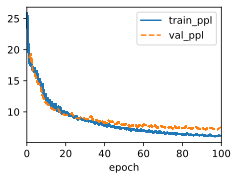

In [5]:
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

Compared with :numref:`sec_rnn-scratch`,
this model achieves comparable perplexity,
but runs faster due to the optimized implementations.
As before, we can generate predicted tokens 
following the specified prefix string.


In [6]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has a a a the the time '

## Summary

* High-level APIs in deep learning frameworks provide implementations of standard RNNs.
* These libraries help you to avoid wasting time reimplementing standard models.
* Framework implementations are often highly optimized, 
  leading to significant (computational) performance gains 
  as compared to implementations from scratch.

## Exercises

1. Can you make the RNN model overfit using the high-level APIs?
1. Implement the autoregressive model of :numref:`sec_sequence` using an RNN.


[Discussions](https://discuss.d2l.ai/t/335)
